# Custom fashion dataset and data pre-processing


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import torch.nn.functional as functional
from torch.utils.data import DataLoader
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
test=pd.read_csv("/content/mnist_test.csv")
train=pd.read_csv("/content/mnist_train.csv")

In [ ]:
test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y_train = train["label"]
X_train=train.drop(labels=["label"],axis=1)
Y_test=test["label"]
X_test=test.drop(labels="label",axis=1)

In [ ]:
X_train.shape

(60000, 784)

In [ ]:
X_train=X_train/255.0
X_test=X_test/255.0

In [ ]:
x_train = torch.tensor(X_train[:10000].values)
y_train = torch.tensor(Y_train[:10000].values)

# test

x_test = torch.tensor(X_test.values)
y_test = torch.tensor(Y_test.values)

# validate

x_validate = torch.tensor(X_train[10000:].values)
y_validate = torch.tensor(Y_train[10000:].values)

In [ ]:
import torch.nn.functional as functional
y_train_one_hot = functional.one_hot(y_train.long(), num_classes = 10)
y_test_one_hot = functional.one_hot(y_test.long(), num_classes = 10)
y_validate_one_hot = functional.one_hot(y_validate.long(), num_classes = 10)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.utils.data as data_utils

batch_size = 64

train_dataset = TensorDataset(x_train.view(-1, 1, 28, 28), y_train_one_hot)
train_data_loader = DataLoader(train_dataset, batch_size, shuffle=True)

validate_dataset = TensorDataset(x_validate.view(-1, 1, 28, 28), y_validate_one_hot)
validate_data_loader = DataLoader(validate_dataset, batch_size, shuffle=True)

In [ ]:
test_dataset = TensorDataset(x_test.view(-1, 1, 28, 28), y_test_one_hot)
test_data_loader = DataLoader(test_dataset, batch_size, shuffle=True)

In [ ]:
from torchvision import transforms
data = next(iter(train_data_loader))
mean = data[0].mean()
std = data[0].std()
print(mean, std)

tensor(0.1309, dtype=torch.float64) tensor(0.3079, dtype=torch.float64)


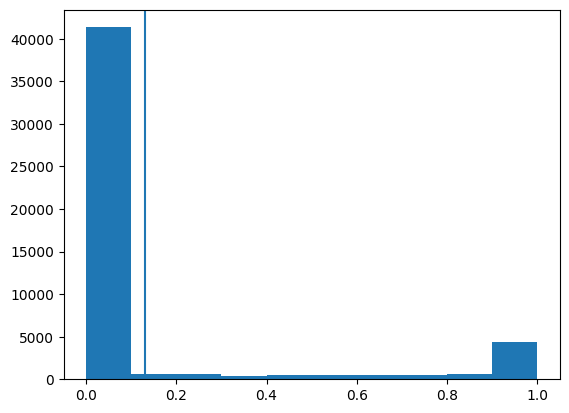

In [ ]:
plt.hist(data[0][:100].flatten())
plt.axvline(mean)

In [ ]:
for i, (images, labels) in enumerate(validate_data_loader):
        # Move tensors to the configured device
        images = images.float().to(device)
        labels = labels.float().to(device)
        print(images.shape)
        print(labels.shape)
        break

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])


# ResNet image classification using Softmax layer + Cross-Entropy loss on Mnist dataset
Note that in PyTorch implementation, the Cross-Entropy loss already has a Softmax layer embedded in itself. Therefore, no Softmax layer was added to the network.

In [ ]:
import torch
import torch.nn as nn


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Instantiate the ResNet model


In [ ]:
num_classes = 10
num_epochs = 100
batch_size = 64
learning_rate = 0.005

model_softmax =  ResNet18().to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_softmax.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


In [ ]:
import time
start_time = time.time()

total_step = len(train_data_loader)
accuracy_softmax_resnet = []
loss_softmax_resnet = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_data_loader):
        # Move tensors to the configured device
        images = images.float().to(device)
        labels = labels.float().to(device)

        # Forward pass
        outputs = model_softmax(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_softmax_resnet.append(loss.item())

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validate_data_loader:
            images = images.float().to(device)
            labels = labels.float().to(device)
            outputs = model_softmax(images)
            _, predicted = torch.max(outputs.data, 1)
            _, l = torch.max(labels, 1)
            total += labels.size(0)

            correct += (predicted == l).sum().item()
            del images, labels, outputs

        accuracy_softmax_resnet.append(100 * correct / total)
        print('Accuracy of the network on the {} validation images: {} %'.format(4000, 100 * correct / total))

end_time = time.time()
elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')


In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_data_loader:
        images = images.float().to(device)
        labels = labels.float().to(device)
        outputs = model_softmax(images)
        _, predicted = torch.max(outputs.data, 1)
        _, l = torch.max(labels, 1)

        total += labels.size(0)
        correct += (predicted == l).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 97.91 %


# ResNet image classification using Softmax layer + Radial loss on Mnist dataset

In [ ]:
import torch
import torch.nn as nn


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out


class ResNet_Softmax(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_Softmax, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)


    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.softmax(out)


        return out


def ResNet_softmax18():
    return ResNet_Softmax(BasicBlock, [2, 2, 2, 2])


# Instantiate the ResNet model


In [ ]:
class RadialLoss(nn.Module):

  def __init__(self):
    super().__init__()

  def forward(self, yHat, y):

    # input shape --> (batch, number_of_classes)
    #theta_radian = torch.acos(torch.sum(yHat* y, dim=-1) / (torch.norm(yHat, dim=1) * torch.norm(y,dim=1)))
    cos_theta = torch.sum(yHat* y, dim=-1) / (torch.norm(yHat, dim=1) * torch.norm(y,dim=1))

    return 1 - cos_theta

In [ ]:
num_classes = 10
num_epochs = 100
batch_size = 64
learning_rate = 0.005

model_radial = ResNet_softmax18().to(device)


# Loss and optimizer
criterion = RadialLoss()
optimizer = torch.optim.SGD(model_radial.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


In [ ]:
import time
start_time = time.time()

total_step = len(train_data_loader)
accuracy_radial_resnet = []

loss_radial_resnet = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_data_loader):
        # Move tensors to the configured device
        images = images.float().to(device)
        labels = labels.float().to(device)

        # Forward pass
        outputs = model_radial(images)
        loss = criterion(outputs, labels).mean()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_radial_resnet.append(loss.item())
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validate_data_loader:
            images = images.float().to(device)
            labels = labels.float().to(device)
            outputs = model_radial(images)

            _, predicted = torch.max(outputs.data, 1)
            _, l = torch.max(labels, 1)

            total += labels.size(0)

            correct += (predicted == l).sum().item()
            del images, labels, outputs

        accuracy_radial_resnet.append(100 * correct / total)
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

end_time = time.time()
elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_data_loader:
        images = images.float().to(device)
        labels = labels.float().to(device)
        outputs = model_radial(images)
        _, predicted = torch.max(outputs.data, 1)
        _, l = torch.max(labels, 1)

        total += labels.size(0)
        correct += (predicted == l).sum().item()
        del images, labels, outputs

print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

Accuracy of the network on the 5000 validation images: 98.74 %


# ResNet image classification using CLR transformer + Mean Square on Mnist dataset


In [ ]:
import torch

def compute_clr_with_epsilon(tensor, epsilon=0.005):
    # Add epsilon only to the zero values
    zero_mask = tensor == 0
    tensor[zero_mask] += epsilon

    # Convert tensor to float data type
    tensor = tensor.float()

    # Compute the row geometric mean
    row_gm = torch.pow(tensor.prod(dim=1), 1 / tensor.shape[1])

    # Divide each element by its row geometric mean
    tensor_div = tensor / row_gm.unsqueeze(1)

    # Take the logarithm (base e) of each element
    tensor_log = torch.log(tensor_div)

    # Subtract the mean of each column from the corresponding column elements
    tensor_clr = tensor_log - tensor_log.mean(dim=0)

    return tensor_clr


In [ ]:
num_classes = 10
num_epochs = 100
batch_size = 64
learning_rate = 0.005

model = ResNet18().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


In [ ]:
y_train_one_hot_clr = compute_clr_with_epsilon(y_train_one_hot.float())

In [ ]:
batch_size = 64

train_dataset = TensorDataset(x_train.view(-1, 1, 28, 28), y_train_one_hot_clr)
train_data_loader_clr = DataLoader(train_dataset, batch_size, shuffle=True)

In [ ]:
import time
start_time = time.time()

total_step = len(train_data_loader)
accuracy_clr_resnet = []
loss_clr_resnet = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_data_loader_clr):
        # Move tensors to the configured device
        images = images.float().to(device)
        labels = labels.float().to(device)
        #labels = compute_clr_with_epsilon(labels.float().to(device))

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_clr_resnet.append(loss.item())
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validate_data_loader:
            images = images.float().to(device)
            labels = labels.float().to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            _, l = torch.max(labels, 1)
            total += labels.size(0)

            correct += (predicted == l).sum().item()
            del images, labels, outputs

        accuracy_clr_resnet.append(100 * correct / total)
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))


end_time = time.time()
elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_data_loader:
        images = images.float().to(device)
        labels = labels.float().to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        _, l = torch.max(labels, 1)

        total += labels.size(0)
        correct += (predicted == l).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 99.27 %
